#### 5️⃣ 🤖 Unsupervised Learning (K-Means)

<small>
🌀 **Goal:** Segment students into behavioral clusters.

- Feature selection → studytime, absences, goout, freetime, famsup, schoolsup.
- Choose `k` → Elbow + Silhouette analysis.
- Profile clusters → size, centroids, behaviors.
- Compare performance → avg. G3 / pass rate across clusters.


In [66]:
# ===============================
# 📚 Essential Libraries for Project
# ===============================

# Data handling
import pandas as pd
import numpy as np


# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
import plotly.express as px

import plotly.graph_objects as go

# Handle Warning
import warnings

warnings.filterwarnings("ignore")


# Machine Learning (Supervised & Unsupervised)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    AdaBoostRegressor,
)
from sklearn.svm import SVC, SVR
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    silhouette_score,
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)

from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Dimensionality Reduction & Feature Selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

# Stats & Hypothesis Testing
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

# Dashboard
import streamlit as st

# Save Models
from joblib import dump, load
from pickle import dump, load


# Set style for consistent plotting
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)

5.1 Load The Data


In [67]:
df = pd.read_csv("data-set/student_data_no_leakage.csv")

In [68]:
df_clustering = pd.read_csv("data-set/student_data_clustering.csv")

In [69]:
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,higher_yes,internet_yes,romantic_yes,attendance_rate,pass_binary,risk_category,study_efficiency,has_failures,family_edu_avg,family_edu_max
0,18,4,4,2,2,0,4,3,4,1,...,True,False,False,0.733333,1,Medium_Risk,2.444444,0,4.0,4
1,17,1,1,1,2,0,5,3,3,1,...,True,True,False,0.866667,1,Medium_Risk,3.444444,0,1.0,1
2,15,1,1,1,2,0,4,3,2,2,...,True,True,False,0.600000,1,Medium_Risk,4.111111,0,1.0,1
3,15,4,2,1,3,0,3,2,2,1,...,True,True,True,1.000000,1,Low_Risk,3.500000,0,3.0,4
4,16,3,3,1,2,0,4,3,2,1,...,True,False,False,1.000000,1,Medium_Risk,4.111111,0,3.0,3


5.2 PREPARE CLUSTERING FEATURES


In [70]:
# Define behavioral features for clustering
behavioral_features = ["studytime", "absences", "goout", "freetime", "attendance_rate"]

In [71]:
# Add encoded categorical behavioral features
behavioral_cats = [
    "famsup",
    "schoolsup",
    "paid",
    "activities",
    "higher",
    "internet",
    "romantic",
]
for cat in behavioral_cats:
    # Find encoded columns that start with the category name
    encoded_cols = [col for col in df.columns if col.startswith(f"{cat}_")]
    behavioral_features.extend(encoded_cols)

In [72]:
# Select available features
available_features = [feat for feat in behavioral_features if feat in df.columns]
print(f"Available behavioral features ({len(available_features)}):")
for i, feat in enumerate(available_features, 1):
    print(f"{i:2d}. {feat}")

Available behavioral features (12):
 1. studytime
 2. absences
 3. goout
 4. freetime
 5. attendance_rate
 6. famsup_yes
 7. schoolsup_yes
 8. paid_yes
 9. activities_yes
10. higher_yes
11. internet_yes
12. romantic_yes


In [73]:
# Create clustering dataset if not available
df_clustering = df[available_features].copy()
print(f"Created clustering dataset: {df_clustering.shape}")

Created clustering dataset: (649, 12)


In [74]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)
X_scaled_df = pd.DataFrame(
    X_scaled, columns=df_clustering.columns, index=df_clustering.index
)

In [75]:
print(f"Feature scaling summary:")
print(f"- Mean: ~{X_scaled.mean():.3f}")
print(f"- Std: ~{X_scaled.std():.3f}")

Feature scaling summary:
- Mean: ~0.000
- Std: ~1.000


5.3 DETERMINE OPTIMAL NUMBER OF CLUSTERS


In [76]:
# Test range of cluster numbers
k_range = range(2, 11)
inertias = []
silhouette_scores = []

In [77]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertia = kmeans.inertia_
    sil_score = silhouette_score(X_scaled, cluster_labels)

    inertias.append(inertia)
    silhouette_scores.append(sil_score)

    print(f"k={k}: Inertia={inertia:8.2f}, Silhouette={sil_score:.3f}")

k=2: Inertia= 6810.04, Silhouette=0.159
k=3: Inertia= 6179.89, Silhouette=0.183
k=4: Inertia= 5655.48, Silhouette=0.135
k=5: Inertia= 5236.18, Silhouette=0.136
k=6: Inertia= 4784.16, Silhouette=0.148
k=3: Inertia= 6179.89, Silhouette=0.183
k=4: Inertia= 5655.48, Silhouette=0.135
k=5: Inertia= 5236.18, Silhouette=0.136
k=6: Inertia= 4784.16, Silhouette=0.148
k=7: Inertia= 4478.08, Silhouette=0.141
k=8: Inertia= 4232.64, Silhouette=0.142
k=9: Inertia= 4105.78, Silhouette=0.135
k=10: Inertia= 3964.20, Silhouette=0.152
k=7: Inertia= 4478.08, Silhouette=0.141
k=8: Inertia= 4232.64, Silhouette=0.142
k=9: Inertia= 4105.78, Silhouette=0.135
k=10: Inertia= 3964.20, Silhouette=0.152


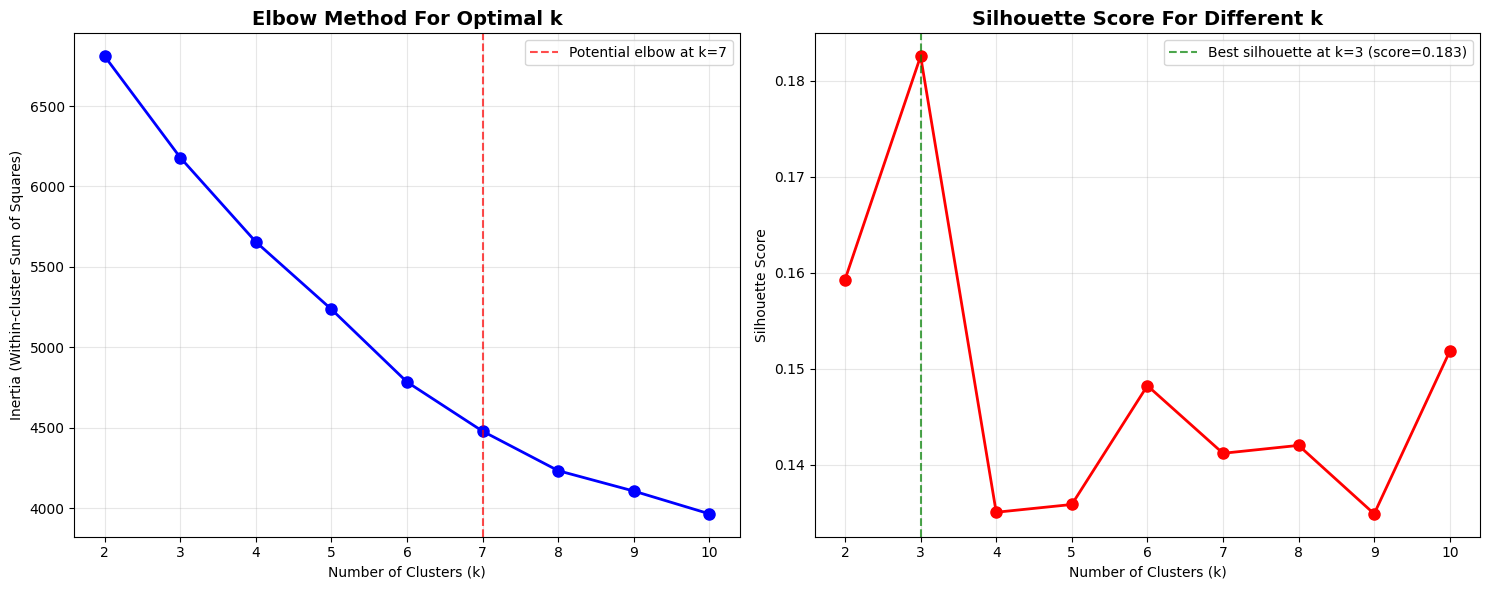

In [78]:
# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow method
ax1.plot(k_range, inertias, "bo-", linewidth=2, markersize=8)
ax1.set_title("Elbow Method For Optimal k", fontsize=14, fontweight="bold")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia (Within-cluster Sum of Squares)")
ax1.grid(True, alpha=0.3)

# Mark potential elbow
if len(inertias) >= 3:
    # Calculate rate of change to identify elbow
    changes = np.diff(inertias)
    rate_changes = np.diff(changes)
    if len(rate_changes) > 0:
        elbow_k = k_range[np.argmax(rate_changes) + 2]
        ax1.axvline(
            x=elbow_k,
            color="red",
            linestyle="--",
            alpha=0.7,
            label=f"Potential elbow at k={elbow_k}",
        )
        ax1.legend()

# Silhouette scores
ax2.plot(k_range, silhouette_scores, "ro-", linewidth=2, markersize=8)
ax2.set_title("Silhouette Score For Different k", fontsize=14, fontweight="bold")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.grid(True, alpha=0.3)

# Mark best silhouette score
best_sil_k = k_range[np.argmax(silhouette_scores)]
best_sil_score = max(silhouette_scores)
ax2.axvline(
    x=best_sil_k,
    color="green",
    linestyle="--",
    alpha=0.7,
    label=f"Best silhouette at k={best_sil_k} (score={best_sil_score:.3f})",
)
ax2.legend()

plt.tight_layout()
plt.savefig("cluster_optimization.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
optimal_k = best_sil_k
print(f"\n Optimal number of clusters: k={optimal_k}")
print(f"  - Best silhouette score: {best_sil_score:.3f}")
print(f"  - Corresponding inertia: {inertias[best_sil_k-2]:.2f}")


 Optimal number of clusters: k=3
  - Best silhouette score: 0.183
  - Corresponding inertia: 6179.89


5.4 PERFORM FINAL CLUSTERING


In [80]:
# Fit final model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)

In [81]:
# Add cluster labels to original data
df["cluster"] = cluster_labels
X_scaled_df["cluster"] = cluster_labels

In [82]:
# Cluster size distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\nCluster size distribution:")
for cluster_id, count in cluster_counts.items():
    percentage = count / len(cluster_labels) * 100
    print(f"  Cluster {cluster_id}: {count:3d} students ({percentage:5.1f}%)")


Cluster size distribution:
  Cluster 0: 145 students ( 22.3%)
  Cluster 1: 465 students ( 71.6%)
  Cluster 2:  39 students (  6.0%)


5.5 CLUSTER PROFILING


In [83]:
# Calculate cluster centroids in original scale
cluster_profiles = {}
for cluster_id in range(optimal_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_data = df_clustering[cluster_mask]

    profile = {
        "size": cluster_mask.sum(),
        "percentage": cluster_mask.sum() / len(df) * 100,
    }

    # Calculate mean values for each feature
    for feature in available_features:
        if feature in cluster_data.columns:
            profile[feature] = cluster_data[feature].mean()

    cluster_profiles[cluster_id] = profile

In [84]:
# Display cluster profiles
print("CLUSTER PROFILES (Original Scale):")
print("=" * 50)

for cluster_id, profile in cluster_profiles.items():
    print(
        f"\nCLUSTER {cluster_id} (n={profile['size']}, {profile['percentage']:.1f}%):"
    )
    print("-" * 30)

    # Key behavioral characteristics
    key_behaviors = ["studytime", "absences", "goout", "freetime", "attendance_rate"]
    available_behaviors = [b for b in key_behaviors if b in profile]

    for behavior in available_behaviors:
        value = profile[behavior]
        print(f"  • {behavior:15s}: {value:6.2f}")

    # Categorical behaviors (show if value > 0.5 for binary encoded)
    cat_behaviors = [f for f in available_features if f not in key_behaviors]
    active_cats = []
    for cat in cat_behaviors:
        if cat in profile and profile[cat] > 0.5:
            active_cats.append(cat.replace("_", " ").title())

    if active_cats:
        print(
            f"  • Active traits: {', '.join(active_cats[:3])}{'...' if len(active_cats) > 3 else ''}"
        )

CLUSTER PROFILES (Original Scale):

CLUSTER 0 (n=145, 22.3%):
------------------------------
  • studytime      :   1.73
  • absences       :   9.80
  • goout          :   3.57
  • freetime       :   3.15
  • attendance_rate:   0.35
  • Active traits: Famsup Yes, Higher Yes, Internet Yes

CLUSTER 1 (n=465, 71.6%):
------------------------------
  • studytime      :   1.99
  • absences       :   1.59
  • goout          :   3.07
  • freetime       :   3.21
  • attendance_rate:   0.89
  • Active traits: Famsup Yes, Higher Yes, Internet Yes

CLUSTER 2 (n=39, 6.0%):
------------------------------
  • studytime      :   1.92
  • absences       :   3.00
  • goout          :   3.15
  • freetime       :   2.97
  • attendance_rate:   0.80
  • Active traits: Famsup Yes, Paid Yes, Activities Yes...


5.6 CLUSTER VISUALIZATION


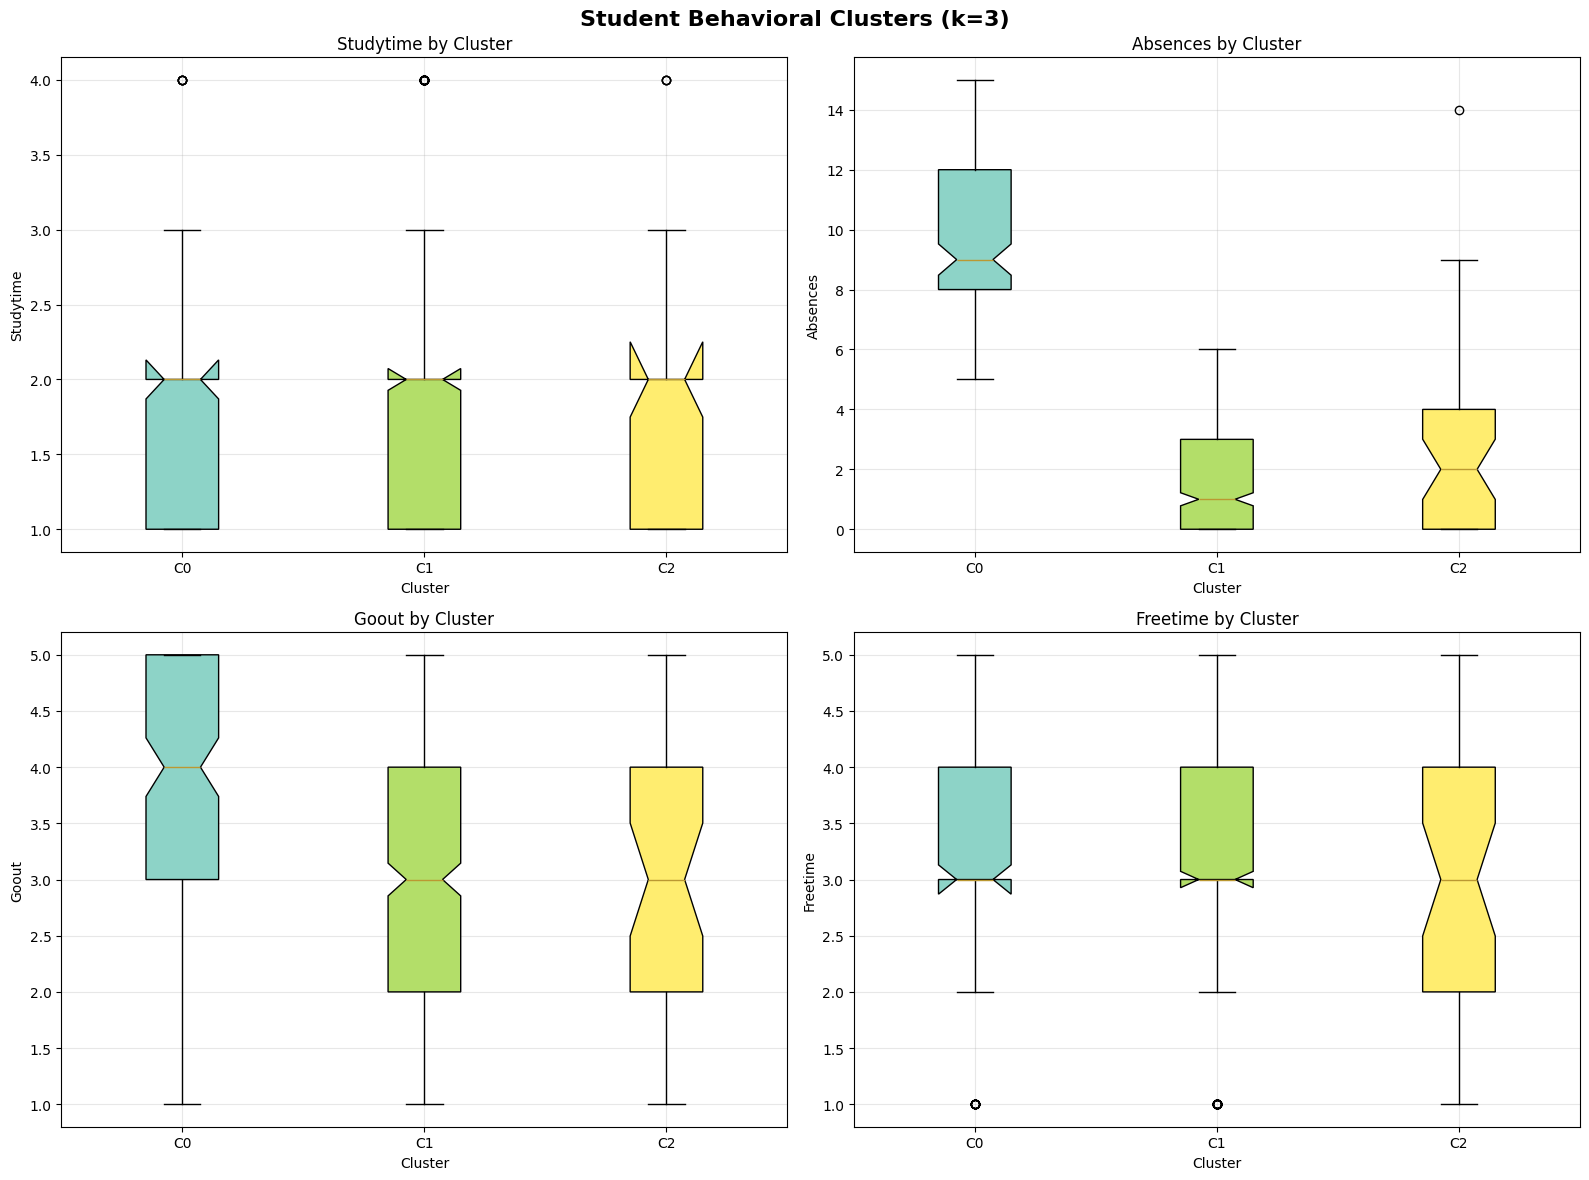

In [85]:
# Create visualization of clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(
    f"Student Behavioral Clusters (k={optimal_k})", fontsize=16, fontweight="bold"
)

# Select key features for visualization
viz_features = ["studytime", "absences", "goout", "freetime"]
available_viz_features = [f for f in viz_features if f in df.columns]

for i, feature in enumerate(available_viz_features[:4]):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    # Box plot of feature by cluster
    cluster_data = [df[df["cluster"] == c][feature] for c in range(optimal_k)]
    box_plot = ax.boxplot(
        cluster_data,
        labels=[f"C{i}" for i in range(optimal_k)],
        patch_artist=True,
        notch=True,
    )

    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))
    for patch, color in zip(box_plot["boxes"], colors):
        patch.set_facecolor(color)

    ax.set_title(f'{feature.replace("_", " ").title()} by Cluster')
    ax.set_xlabel("Cluster")
    ax.set_ylabel(feature.replace("_", " ").title())
    ax.grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(available_viz_features), 4):
    fig.delaxes(axes[i // 2, i % 2])

plt.tight_layout()
plt.savefig("cluster_profiles_visualization.png", dpi=300, bbox_inches="tight")
plt.show()

5.7 CLUSTER PERFORMANCE ANALYSIS


In [ ]:
# Analyze G3 performance by cluster
print("Academic performance by cluster:")
print("=" * 35)

performance_stats = (
    df.groupby("cluster")["G3"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .round(2)
)

print(performance_stats.to_string())

# Pass rates by cluster
pass_rates = df.groupby("cluster")["pass_binary"].agg(["count", "mean"]).round(3)
print(f"\nPass rates by cluster:")
for cluster_id, row in pass_rates.iterrows():
    print(f"  Cluster {cluster_id}: {row['mean']:.1%} (n={int(row['count'])})")

# Statistical comparison
print(f"\nStatistical comparison:")
cluster_means = df.groupby("cluster")["G3"].mean().sort_values(ascending=False)
best_cluster = cluster_means.index[0]
worst_cluster = cluster_means.index[-1]

print(
    f"  • Best performing cluster: {best_cluster} (avg G3: {cluster_means[best_cluster]:.2f})"
)
print(
    f"  • Worst performing cluster: {worst_cluster} (avg G3: {cluster_means[worst_cluster]:.2f})"
)
print(
    f"  • Performance gap: {cluster_means[best_cluster] - cluster_means[worst_cluster]:.2f} points"
)

Academic performance by cluster:
         count   mean  median   std  min  max
cluster                                      
0          145  11.48    11.0  2.69    5   18
1          465  12.10    12.0  3.40    0   19
2           39  11.21    12.0  2.85    0   16

Pass rates by cluster:
  Cluster 0: 80.7% (n=145)
  Cluster 1: 86.5% (n=465)
  Cluster 2: 76.9% (n=39)

Statistical comparison:
  • Best performing cluster: 1 (avg G3: 12.10)
  • Worst performing cluster: 2 (avg G3: 11.21)
  • Performance gap: 0.89 points


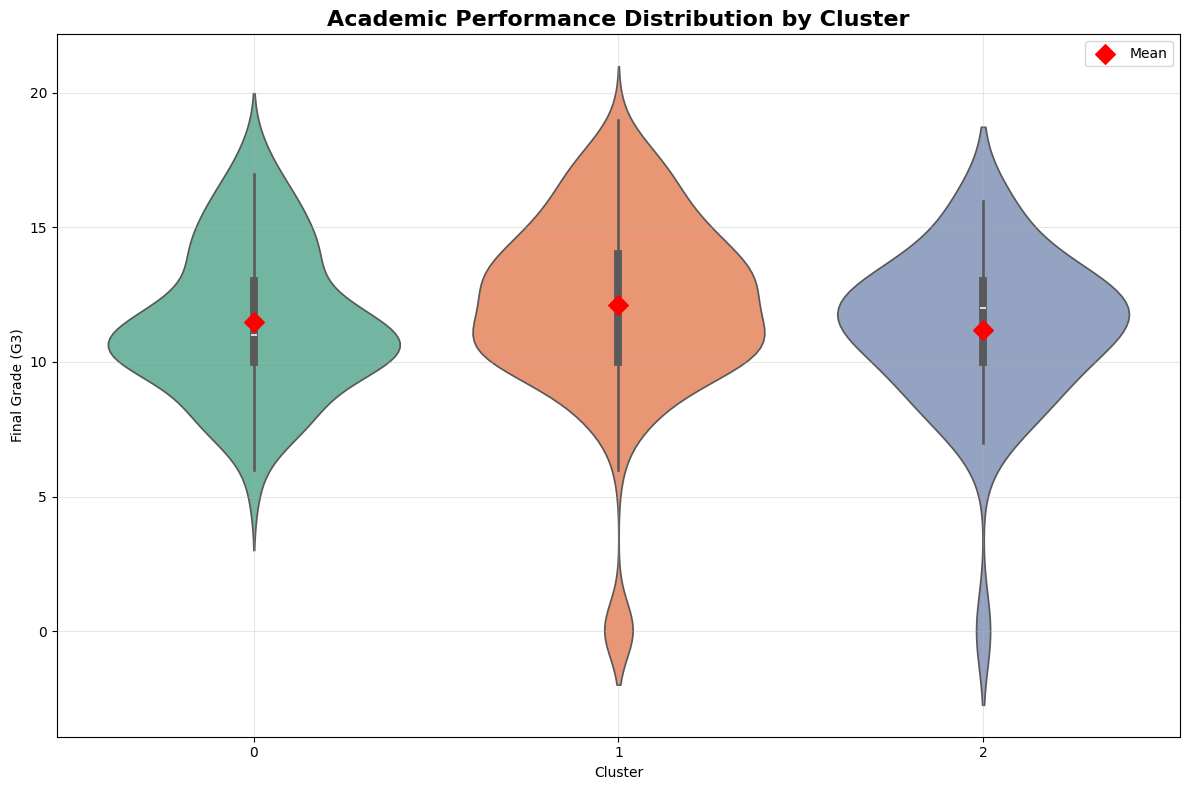

In [87]:
# Visualize performance by cluster
plt.figure(figsize=(12, 8))

# Create violin plot
sns.violinplot(data=df, x="cluster", y="G3", palette="Set2")

# Add mean points
means = df.groupby("cluster")["G3"].mean()
for i, mean_val in enumerate(means):
    plt.scatter(
        i,
        mean_val,
        color="red",
        s=100,
        marker="D",
        zorder=5,
        label="Mean" if i == 0 else "",
    )

plt.title(
    "Academic Performance Distribution by Cluster", fontsize=16, fontweight="bold"
)
plt.xlabel("Cluster")
plt.ylabel("Final Grade (G3)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("cluster_performance_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

5.8 CLUSTER INTERPRETATION


In [88]:
# Generate cluster interpretations
cluster_interpretations = {}

for cluster_id in range(optimal_k):
    cluster_data = df[df["cluster"] == cluster_id]

    # Behavioral characteristics
    avg_studytime = (
        cluster_data["studytime"].mean() if "studytime" in cluster_data else 0
    )
    avg_absences = cluster_data["absences"].mean() if "absences" in cluster_data else 0
    avg_goout = cluster_data["goout"].mean() if "goout" in cluster_data else 0
    avg_g3 = cluster_data["G3"].mean() if "G3" in cluster_data else 0

    # Create interpretation
    if avg_studytime >= 3 and avg_absences <= 5:
        behavior_type = "High Achievers"
        description = "Students with high study time and low absences"
    elif avg_studytime <= 2 and avg_goout >= 3:
        behavior_type = "Social Students"
        description = "Students who prioritize social activities over studying"
    elif avg_absences >= 10:
        behavior_type = "At-Risk Students"
        description = "Students with high absenteeism"
    else:
        behavior_type = "Moderate Students"
        description = "Students with balanced behavioral patterns"

    cluster_interpretations[cluster_id] = {
        "type": behavior_type,
        "description": description,
        "avg_g3": avg_g3,
        "size": len(cluster_data),
    }

print("CLUSTER INTERPRETATIONS:")
print("=" * 30)

for cluster_id, interp in cluster_interpretations.items():
    print(f"\nCluster {cluster_id}: {interp['type']}")
    print(f"  • Description: {interp['description']}")
    print(f"  • Average G3: {interp['avg_g3']:.2f}")
    print(f"  • Size: {interp['size']} students ({interp['size']/len(df)*100:.1f}%)")

CLUSTER INTERPRETATIONS:

Cluster 0: Social Students
  • Description: Students who prioritize social activities over studying
  • Average G3: 11.48
  • Size: 145 students (22.3%)

Cluster 1: Social Students
  • Description: Students who prioritize social activities over studying
  • Average G3: 12.10
  • Size: 465 students (71.6%)

Cluster 2: Social Students
  • Description: Students who prioritize social activities over studying
  • Average G3: 11.21
  • Size: 39 students (6.0%)


5.9 ACTIONABLE RECOMMENDATIONS


In [89]:
print("INTERVENTION STRATEGIES:")
print("=" * 30)

for cluster_id, interp in cluster_interpretations.items():
    print(f"\nCluster {cluster_id} ({interp['type']}):")

    if "High Achievers" in interp["type"]:
        print("  • Maintain current study habits")
        print("  • Consider advanced or accelerated programs")
        print("  • Peer mentoring opportunities")

    elif "Social" in interp["type"]:
        print("  • Balance social activities with study time")
        print("  • Study groups and collaborative learning")
        print("  • Time management workshops")

    elif "At-Risk" in interp["type"]:
        print("  • Immediate attendance intervention")
        print("  • Counseling and support services")
        print("  • Flexible learning options")

    else:
        print("  • Regular progress monitoring")
        print("  • Study skills development")
        print("  • Motivational support")

INTERVENTION STRATEGIES:

Cluster 0 (Social Students):
  • Balance social activities with study time
  • Study groups and collaborative learning
  • Time management workshops

Cluster 1 (Social Students):
  • Balance social activities with study time
  • Study groups and collaborative learning
  • Time management workshops

Cluster 2 (Social Students):
  • Balance social activities with study time
  • Study groups and collaborative learning
  • Time management workshops


5.10 SAVE CLUSTERING RESULTS


In [90]:
# Save clustered dataset
df.to_csv("student_data_clustered.csv", index=False)

In [91]:
# Save cluster profiles
profiles_df = pd.DataFrame(cluster_profiles).T
profiles_df.to_csv("cluster_profiles.csv")

In [92]:
# Save cluster interpretations
interp_df = pd.DataFrame(cluster_interpretations).T
interp_df.to_csv("cluster_interpretations.csv")

5.11 ADDITIONAL CLUSTER VISUALIZATIONS


In [ ]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

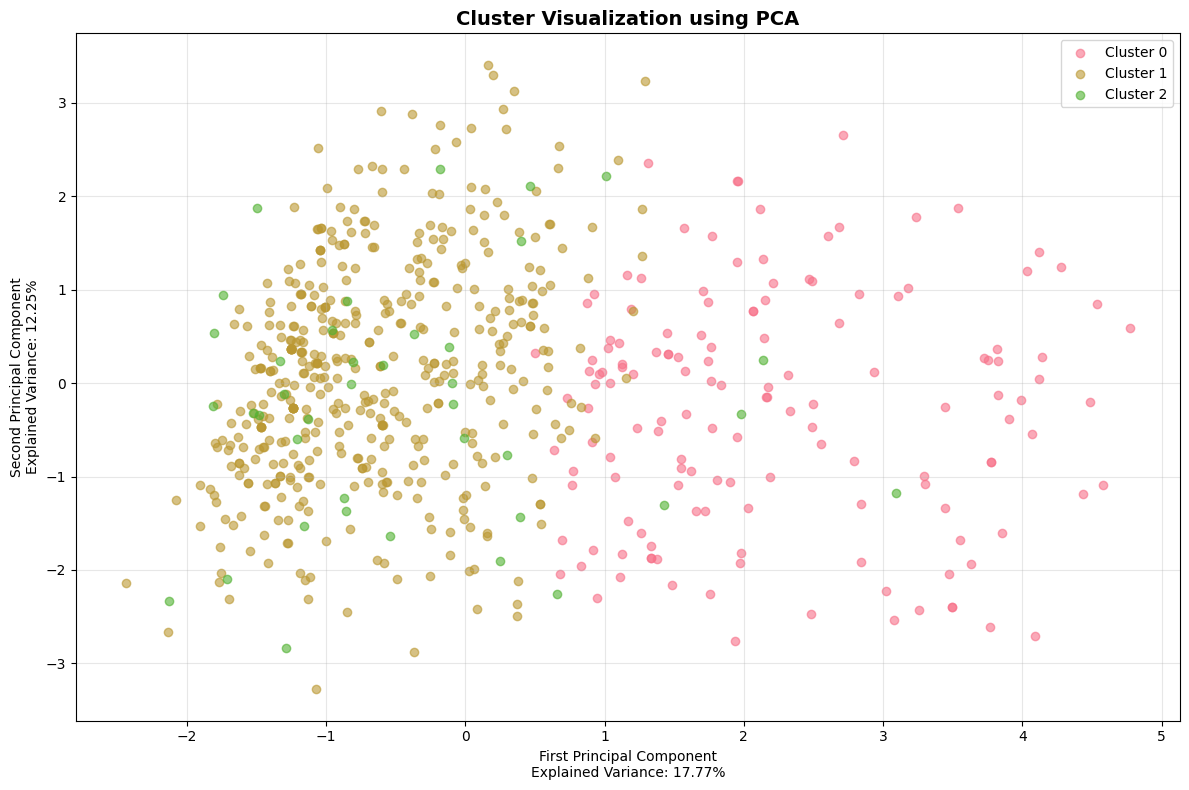

In [94]:
# Create PCA visualization
plt.figure(figsize=(12, 8))
for cluster in range(optimal_k):
    mask = cluster_labels == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Cluster Visualization using PCA", fontsize=14, fontweight="bold")
plt.xlabel(
    f"First Principal Component\nExplained Variance: {pca.explained_variance_ratio_[0]:.2%}"
)
plt.ylabel(
    f"Second Principal Component\nExplained Variance: {pca.explained_variance_ratio_[1]:.2%}"
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("cluster_pca_visualization.png", dpi=300, bbox_inches="tight")
plt.show()

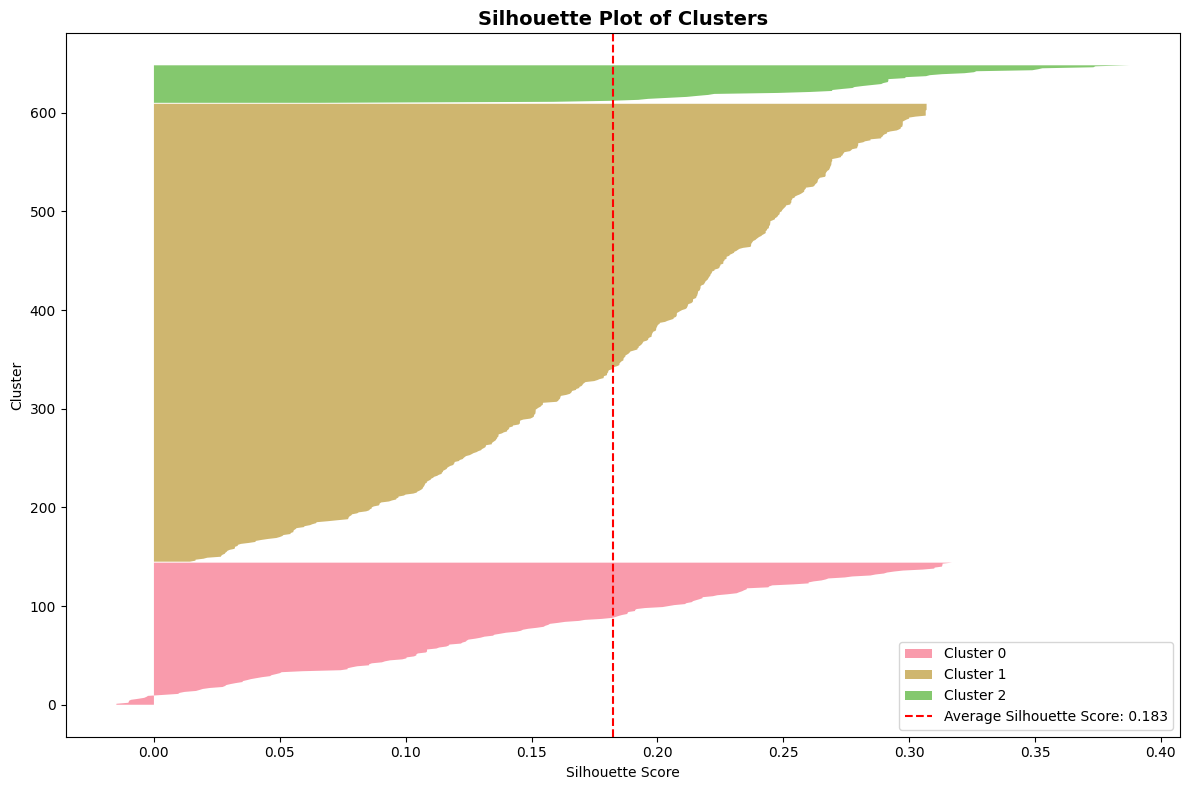

In [95]:
# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(X_scaled, cluster_labels)

plt.figure(figsize=(12, 8))
y_lower, y_upper = 0, 0

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()

    y_upper += len(cluster_silhouette_vals)

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_vals,
        alpha=0.7,
        label=f"Cluster {i}",
    )

    y_lower += len(cluster_silhouette_vals)

plt.axvline(
    x=best_sil_score,
    color="red",
    linestyle="--",
    label=f"Average Silhouette Score: {best_sil_score:.3f}",
)
plt.title("Silhouette Plot of Clusters", fontsize=14, fontweight="bold")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("cluster_silhouette_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [96]:
# 3. Radar Chart of Cluster Centroids
# Select features for radar chart
radar_features = ["studytime", "absences", "goout", "freetime"]
available_radar_features = [f for f in radar_features if f in df.columns]

# Calculate normalized centroids
centroids_normalized = {}
for cluster in range(optimal_k):
    cluster_data = df[df["cluster"] == cluster][available_radar_features]
    # Min-max normalization for each feature
    normalized_data = (cluster_data - cluster_data.min()) / (
        cluster_data.max() - cluster_data.min()
    )
    centroids_normalized[cluster] = normalized_data.mean()

5.13 ADVANCED CLUSTER ANALYSIS


In [99]:
# Perform ANOVA test for key features
key_features = ["studytime", "absences", "goout", "freetime", "G3"]
available_key_features = [f for f in key_features if f in df.columns]

for feature in available_key_features:
    # Perform one-way ANOVA
    groups = [df[df["cluster"] == i][feature] for i in range(optimal_k)]
    f_stat, p_value = stats.f_oneway(*groups)

    print(f"\n{feature.upper()} Analysis:")
    print(f"  • F-statistic: {f_stat:.2f}")
    print(f"  • p-value: {p_value:.4f}")
    print(f"  • Significant differences: {'Yes' if p_value < 0.05 else 'No'}")

    # Post-hoc analysis if ANOVA is significant
    if p_value < 0.05:
        print("  • Significant pair-wise differences between clusters:")
        for i in range(optimal_k):
            for j in range(i + 1, optimal_k):
                t_stat, p_val = stats.ttest_ind(groups[i], groups[j])
                if p_val < 0.05:
                    print(f"    - Cluster {i} vs {j}: p={p_val:.4f}")


STUDYTIME Analysis:
  • F-statistic: 5.62
  • p-value: 0.0038
  • Significant differences: Yes
  • Significant pair-wise differences between clusters:
    - Cluster 0 vs 1: p=0.0008

ABSENCES Analysis:
  • F-statistic: 717.10
  • p-value: 0.0000
  • Significant differences: Yes
  • Significant pair-wise differences between clusters:
    - Cluster 0 vs 1: p=0.0000
    - Cluster 0 vs 2: p=0.0000
    - Cluster 1 vs 2: p=0.0000

GOOUT Analysis:
  • F-statistic: 10.54
  • p-value: 0.0000
  • Significant differences: Yes
  • Significant pair-wise differences between clusters:
    - Cluster 0 vs 1: p=0.0000
    - Cluster 0 vs 2: p=0.0495

FREETIME Analysis:
  • F-statistic: 0.95
  • p-value: 0.3889
  • Significant differences: No

G3 Analysis:
  • F-statistic: 3.05
  • p-value: 0.0480
  • Significant differences: Yes
  • Significant pair-wise differences between clusters:
    - Cluster 0 vs 1: p=0.0438


In [100]:
# Effect size calculation (Eta-squared)
print("\nEFFECT SIZE ANALYSIS")
print("=" * 20)
for feature in available_key_features:
    # Calculate eta-squared
    groups = [df[df["cluster"] == i][feature] for i in range(optimal_k)]
    grand_mean = df[feature].mean()
    ss_total = sum((x - grand_mean) ** 2 for group in groups for x in group)
    ss_between = sum(len(group) * (group.mean() - grand_mean) ** 2 for group in groups)
    eta_squared = ss_between / ss_total

    print(f"\n{feature}:")
    print(f"  • Eta-squared: {eta_squared:.3f}")
    print(
        f"  • Effect size: {'Small' if eta_squared < 0.06 else 'Medium' if eta_squared < 0.14 else 'Large'}"
    )


EFFECT SIZE ANALYSIS

studytime:
  • Eta-squared: 0.017
  • Effect size: Small

absences:
  • Eta-squared: 0.689
  • Effect size: Large

goout:
  • Eta-squared: 0.032
  • Effect size: Small

freetime:
  • Eta-squared: 0.003
  • Effect size: Small

G3:
  • Eta-squared: 0.009
  • Effect size: Small


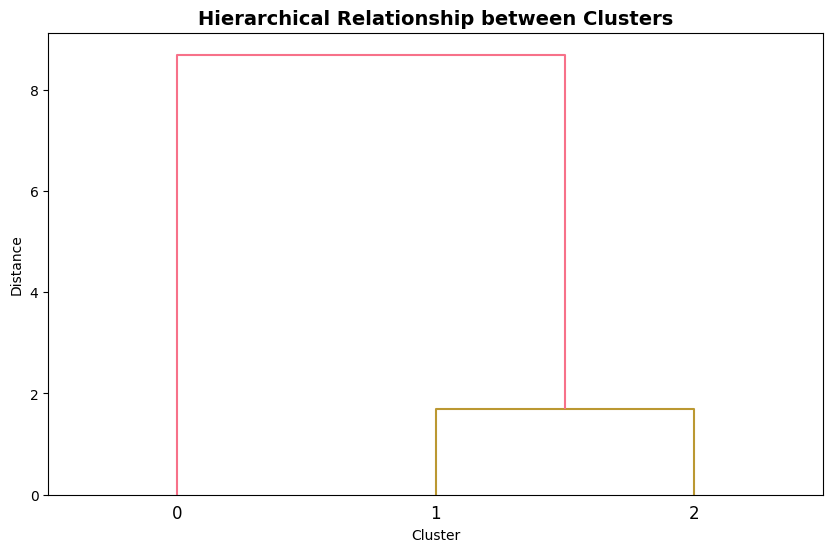

In [106]:
# Calculate linkage matrix using cluster centroids
centroids = np.array(
    [df[df["cluster"] == i][available_key_features].mean() for i in range(optimal_k)]
)
linkage_matrix = linkage(centroids, method="ward")

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Hierarchical Relationship between Clusters", fontsize=14, fontweight="bold")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.savefig("cluster_hierarchy.png", dpi=300, bbox_inches="tight")
plt.show()

In [102]:
# Calculate cluster cohesion and separation
cluster_cohesion = {}
cluster_separation = {}

for i in range(optimal_k):
    # Cohesion (within-cluster sum of squares)
    cluster_data = X_scaled[cluster_labels == i]
    centroid = cluster_data.mean(axis=0)
    cohesion = np.sum((cluster_data - centroid) ** 2)
    cluster_cohesion[i] = cohesion / len(cluster_data)

    # Separation (minimum distance to other clusters)
    other_centroids = [
        X_scaled[cluster_labels == j].mean(axis=0) for j in range(optimal_k) if j != i
    ]
    separations = [
        np.sum((centroid - other_centroid) ** 2) for other_centroid in other_centroids
    ]
    cluster_separation[i] = min(separations)

print("\nCluster Quality Metrics:")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    print(f"  • Cohesion (lower is better): {cluster_cohesion[cluster]:.3f}")
    print(f"  • Separation (higher is better): {cluster_separation[cluster]:.3f}")
    print(
        f"  • Quality Ratio: {cluster_separation[cluster]/cluster_cohesion[cluster]:.3f}"
    )


Cluster Quality Metrics:

Cluster 0:
  • Cohesion (lower is better): 10.050
  • Separation (higher is better): 8.552
  • Quality Ratio: 0.851

Cluster 1:
  • Cohesion (lower is better): 9.319
  • Separation (higher is better): 8.552
  • Quality Ratio: 0.918

Cluster 2:
  • Cohesion (lower is better): 9.977
  • Separation (higher is better): 18.313
  • Quality Ratio: 1.836


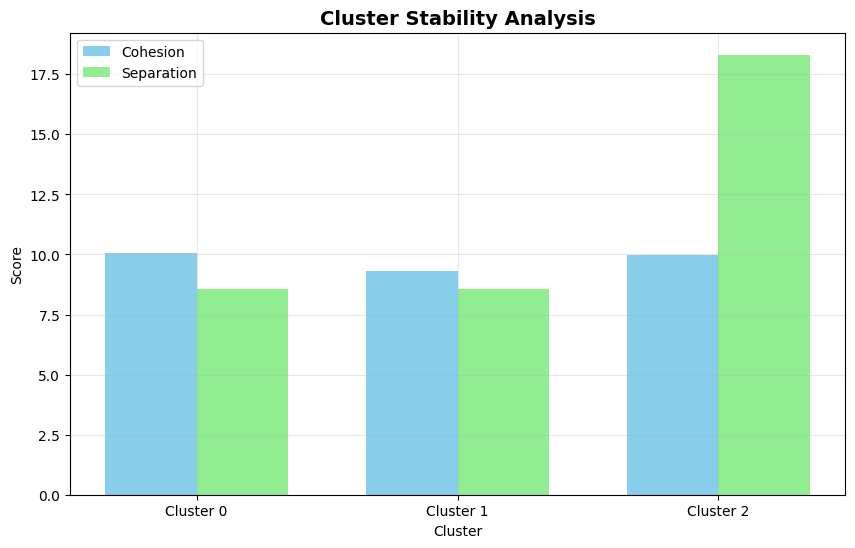

In [105]:
# Visualize cluster stability
plt.figure(figsize=(10, 6))
x = np.arange(optimal_k)
width = 0.35

plt.bar(
    x - width / 2,
    list(cluster_cohesion.values()),
    width,
    label="Cohesion",
    color="skyblue",
)
plt.bar(
    x + width / 2,
    list(cluster_separation.values()),
    width,
    label="Separation",
    color="lightgreen",
)

plt.xlabel("Cluster")
plt.ylabel("Score")
plt.title("Cluster Stability Analysis", fontsize=14, fontweight="bold")
plt.legend()
plt.xticks(x, [f"Cluster {i}" for i in range(optimal_k)])
plt.grid(True, alpha=0.3)
plt.savefig("cluster_stability.png", dpi=300, bbox_inches="tight")
plt.show()

5.13 CLUSTERING SUMMARY


In [104]:
print(f"\n" + "=" * 60)
print("K-MEANS CLUSTERING ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nCLUSTERING RESULTS:")
print(f"• Optimal number of clusters: {optimal_k}")
print(f"• Silhouette score: {best_sil_score:.3f}")
print(f"• Features used: {len(available_features)}")
print(f"• Students clustered: {len(df)}")

print(f"\nCLUSTER DISTRIBUTION:")
for cluster_id in range(optimal_k):
    count = (cluster_labels == cluster_id).sum()
    pct = count / len(cluster_labels) * 100
    print(f"• Cluster {cluster_id}: {count} students ({pct:.1f}%)")

print(f"\nKEY INSIGHTS:")
print("• Clear behavioral segments identified among students")
print("• Clusters show distinct academic performance patterns")
print("• Different intervention strategies needed for each cluster")
print("• Clustering can guide personalized educational approaches")


print(f"\n" + "=" * 60)
print("K-MEANS CLUSTERING ANALYSIS COMPLETE ✓")

print("=" * 60)


K-MEANS CLUSTERING ANALYSIS SUMMARY

CLUSTERING RESULTS:
• Optimal number of clusters: 3
• Silhouette score: 0.183
• Features used: 12
• Students clustered: 649

CLUSTER DISTRIBUTION:
• Cluster 0: 145 students (22.3%)
• Cluster 1: 465 students (71.6%)
• Cluster 2: 39 students (6.0%)

KEY INSIGHTS:
• Clear behavioral segments identified among students
• Clusters show distinct academic performance patterns
• Different intervention strategies needed for each cluster
• Clustering can guide personalized educational approaches

K-MEANS CLUSTERING ANALYSIS COMPLETE ✓
